In this notebook, let us try and explore the data given for Zillow prize competition. Before we dive deep into the data, let us know a little more about the competition.

**Zillow:**

Zillow is an online real estate database company founded in 2006 - Wikipedia

**Zestimate:**

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today),

**Objective:**

Building a model to improve the Zestimate residual error.

The competition is in two stages. This public competition will go on till Jan 2018 and has $50,000 in prize. Please make sure to read about the [Prize details][1] and [Competition overview][2] since it is quite different in this one.

Let us first import the necessary modules.


  [1]: https://www.kaggle.com/c/zillow-prize-1#prizes
  [2]: https://www.kaggle.com/c/zillow-prize-1#Competition%20Overview

In [1]:
import numpy as np # linear algebra, the main (only real?) option for handling vectors/matrices
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # plotting, specialized for statistical fata (distributions, etc) and colorful visualization
color = sns.color_palette()

# for displaying plots inside the notebook
%matplotlib inline 

Let us list the files present in the input folder.

In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

properties_2016.csv
sample_submission.csv
train_2016_v2.csv
zillow_data_dictionary.xlsx



# Explore training data

In [3]:
# read the data from a CSV file, and put it in a Pandas "dataframe" (~ a table, but with lots of fancy features)
train_df = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.shape

(90275, 3)

In [4]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


**Logerror:**

Target variable for this competition is "logerror" field. So let us do some analysis on this field first. 

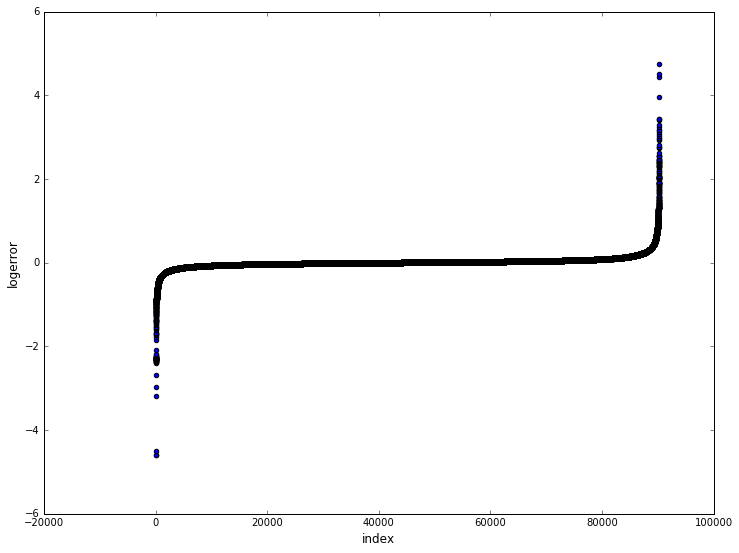

In [5]:
plt.figure(figsize=(12,9))
# notice that we sort the y-values = the log error
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Looks like most data points (=houses) have a log error between -1 and +1, with several outliers on both ends.
Next common step: plot a histogram to see how many points are actually in each bucket.

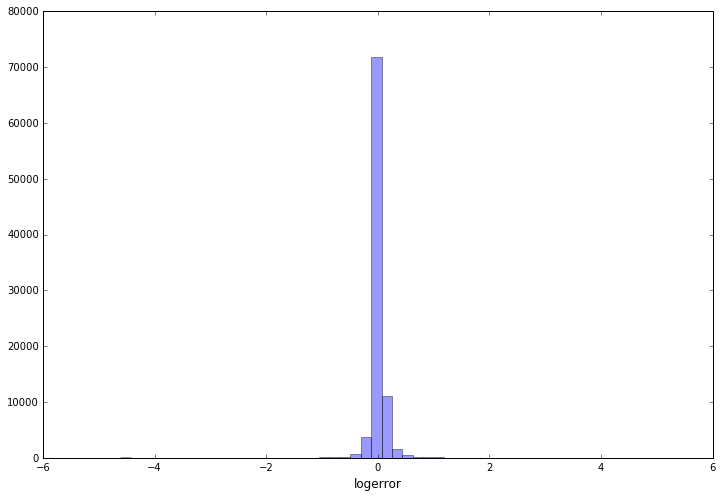

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Outliers are making it hard to see the distribution for the majority of the data. We are going to remove outliers (top and bottom percentiles; this is an arbitrary choice, should be re-examined always)

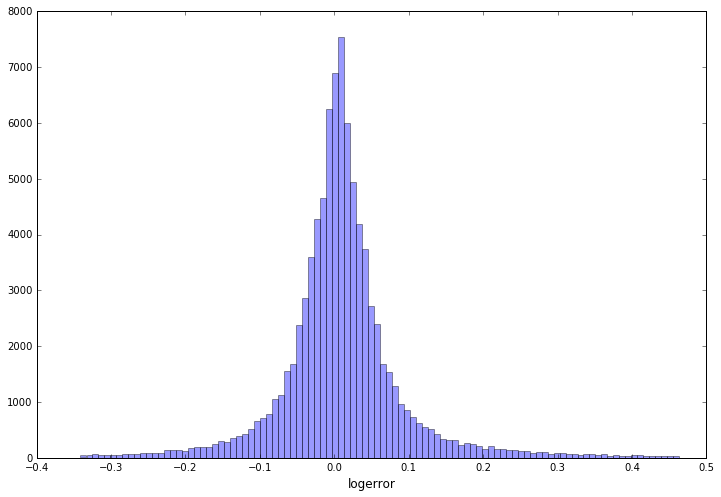

In [7]:
ulimit = np.percentile(train_df.logerror.values, 99)
llimit = np.percentile(train_df.logerror.values, 1)
train_df_without_outliers = train_df[(train_df['logerror']<ulimit) & (train_df['logerror']>llimit)].copy()
train_df_outliers = train_df[(train_df['logerror']>=ulimit) | (train_df['logerror']<=llimit)].copy()

plt.figure(figsize=(12,8))
sns.distplot(train_df_without_outliers.logerror.values, bins=100, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

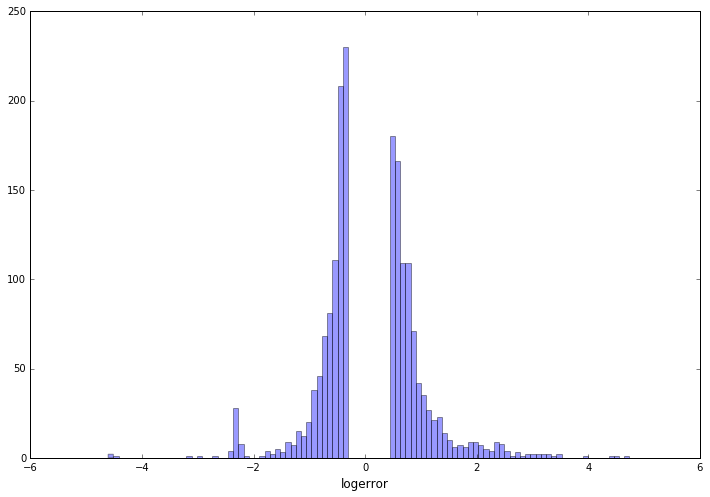

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(train_df_outliers.logerror.values, bins=100, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

**Transaction Date:**

Now let us explore the date field. Let us first check the number of transactions in each month. 

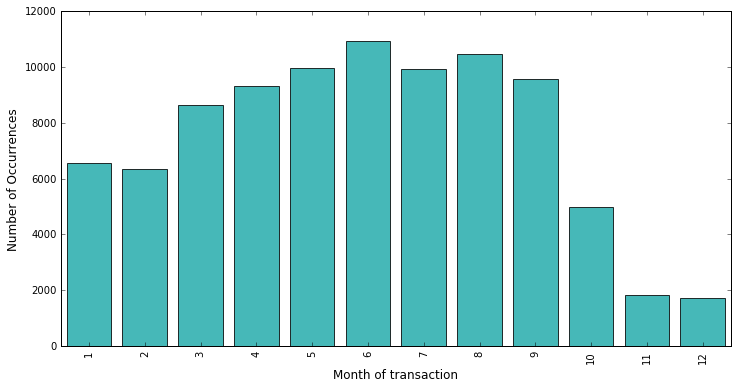

In [9]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

count_event_per_month = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(count_event_per_month.index, count_event_per_month.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

As we could see from the data page as well
*The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.*

So we have shorter bars in the last three months. 

**Parcel Id:**

In [10]:
# We want to count how many times each parcel appears in the train dataset
grouped = train_df.groupby('parcelid')
counted = grouped['parcelid'].agg(['count'])
counted['count'].value_counts()

1    90026
2      123
3        1
Name: count, dtype: int64

So most of the parcel ids are appearing only once in the dataset.

## Look at the properties data:

Now let us explore the properties_2016 file. 

In [11]:
prop_df = pd.read_csv("../input/properties_2016.csv")
prop_df.shape

/Users/adrienctx/anaconda/envs/dev3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)

So, almost 3M properties listed, and 58 features

In [12]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


There are so many NaN values in the dataset. So let us first do some exploration on that one. 

In [49]:
# convert each cell value to True/False (isnull?), then sum over the columns (=count the "True"'s for each column)
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
# only keep the rows that have at least 1 missing value
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df.tail(10)

,column_name,missing_count
16,finishedsquarefeet6,2963216
9,decktypeid,2968121
6,buildingclasstypeid,2972588
13,finishedsquarefeet13,2977545
43,typeconstructiontypeid,2978470
2,architecturalstyletypeid,2979156
49,fireplaceflag,2980054
46,yardbuildingsqft26,2982570
3,basementsqft,2983589
41,storytypeid,2983593


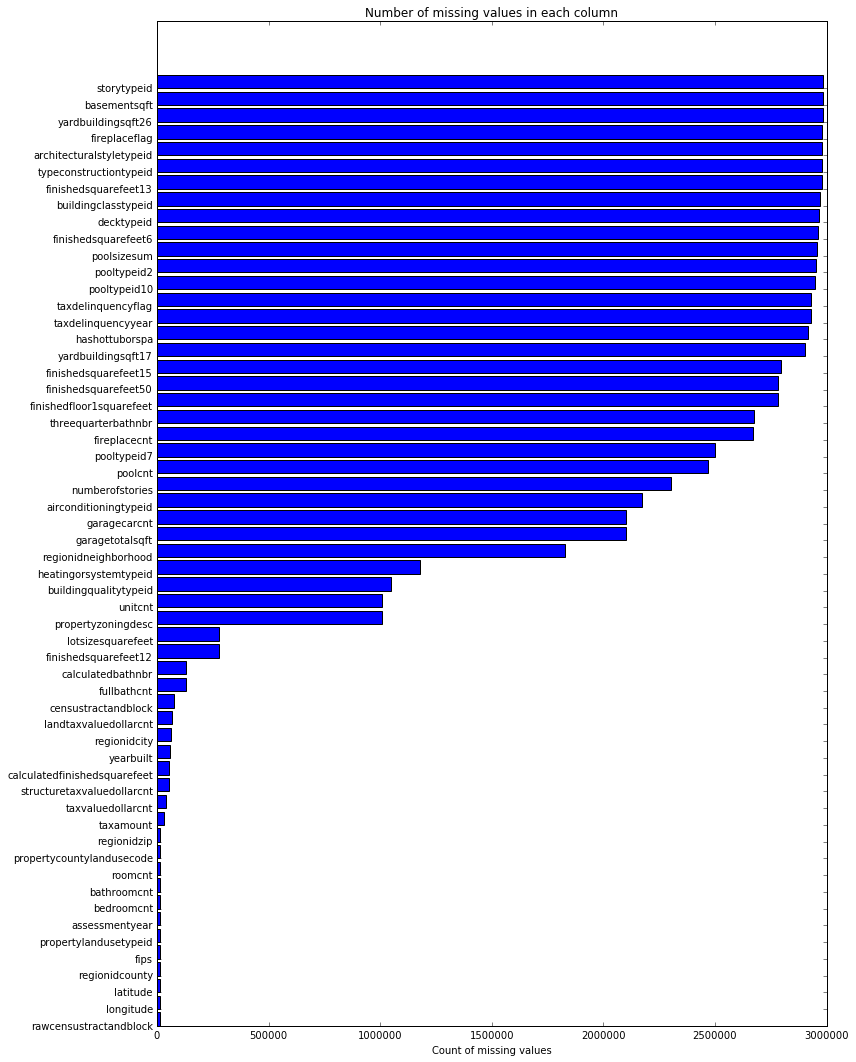

In [50]:
# Create an index vector
ind = np.arange(missing_df.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
# doing a horizontal bar plot, with value shown being the missing value count from previous cell
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

This is __a lot of missing values__ for some features (near 100%). __We'll have to decide what to do with those__: (1)remove them entirely or (2)fill the missing value with mean/something else.

### Bivariate analysis

Let us explore the latitude and longitude variable to begin with.

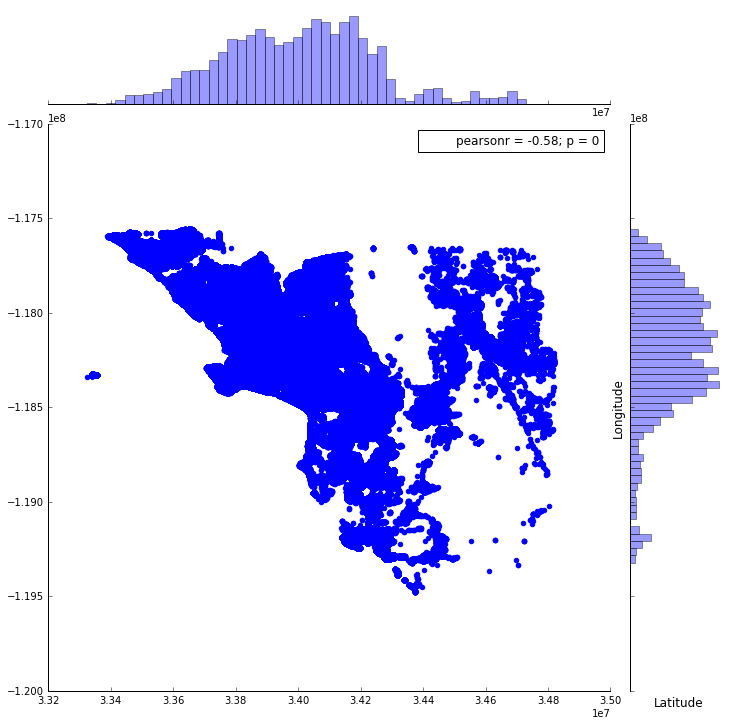

In [15]:
plt.figure(figsize=(12,12))
# The jointplot method is used for doing bivariate analysis (it has a lot of cool options!)
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

From the data page, *we are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.*

We have about 90,811 rows in train but we have about 2,985,217 rows in properties file. So let us merge the two files and then carry out our analysis. 
This will add all the property info to the transaction data (=train data)

In [16]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


### Quickly check the data types

Now let us check the dtypes of different types of variable.

In [17]:
pd.options.display.max_rows = 65 #for readability

# Get the Series of pairs (column names, its data type)
dtype_df = train_df.dtypes.reset_index()
# Rename correctly (often it's messed up by the reset_index)
dtype_df.columns = ["Feature name", "dtype"]
dtype_df

,Feature name,dtype
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


Almost all are float variables with few object (categorical) variables. Let us get the count. 

In [18]:
# Like before, we want to count the number of occurences of certain values (here, the dtype values)
dtype_count = dtype_df.groupby('dtype').aggregate('count').reset_index()
dtype_count.columns = ['dtype','number of occurences']
dtype_count.head()

,dtype,number of occurences
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


## Looking into missing values

Now let us check the number of Nulls in this new merged dataset.

In [19]:
# convert each cell value to True/False (isnull?), then sum over the columns (=count the "True"'s for each column)
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['feature_name', 'missing_count']
# also get the ratio of the null values for each feature
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df[missing_df['missing_ratio']>0.99]

,feature_name,missing_count,missing_ratio
5,architecturalstyletypeid,90014,0.997109
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
12,decktypeid,89617,0.992711
16,finishedsquarefeet13,90242,0.999634
19,finishedsquarefeet6,89854,0.995336
44,storytypeid,90232,0.999524
46,typeconstructiontypeid,89976,0.996688
49,yardbuildingsqft26,90180,0.998948
52,fireplaceflag,90053,0.997541


Ten columns have missing values 99% of the times !
Let's look into these missing values: 

* are they just accidents? ("We forgot to type in the square meters for the kitchen") -> replace by mean
* are they hidden binary? (1.0 = there is a fireplace, Null = there is no fireplace) -> replace by 0
* are they something else? (building type is either 4.0 or 7.0... Null is what??) -> :(

In [20]:
missing_df['nb_unique_values'] = missing_df.apply(lambda x: len(train_df[x['feature_name']].unique()), axis=1)
missing_df['dtype'] = missing_df.apply(lambda x: train_df.dtypes[x['feature_name']], axis=1)
missing_df = missing_df.sort_values('missing_ratio', ascending=False)
missing_df.head(20)

,feature_name,missing_count,missing_ratio,nb_unique_values,dtype
9,buildingclasstypeid,90259,0.999823,2,float64
16,finishedsquarefeet13,90242,0.999634,12,float64
6,basementsqft,90232,0.999524,40,float64
44,storytypeid,90232,0.999524,2,float64
49,yardbuildingsqft26,90180,0.998948,74,float64
52,fireplaceflag,90053,0.997541,2,object
5,architecturalstyletypeid,90014,0.997109,7,float64
46,typeconstructiontypeid,89976,0.996688,4,float64
19,finishedsquarefeet6,89854,0.995336,361,float64
12,decktypeid,89617,0.992711,2,float64


In [21]:
missing_df[missing_df['feature_name'] == 'heatingorsystemtypeid']

,feature_name,missing_count,missing_ratio,nb_unique_values,dtype
26,heatingorsystemtypeid,34195,0.378787,13,float64


In [22]:
train_df.heatingorsystemtypeid.unique()

array([  2.,  nan,   7.,   6.,  24.,  13.,  20.,  18.,  11.,   1.,  14.,
        12.,  10.])

### Question: can we come up with an automated way of dealing with the missing data? Test your logic on the above variables

For example, does it work on both *poolsizesum* and *fireplaceflag*? And *buildingclasstypeid* ?

## Correlation between variables:


In [23]:
# Let us just impute the missing values with mean values to compute correlation coefficients #
mean_values = train_df.mean(axis=0)
train_df_null_to_mean = train_df.copy()
train_df_null_to_mean.fillna(mean_values, inplace=True)

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.000000,7.229885,713.581395,2.0,3.0,4.0,...,1.440739,1,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,13.402692,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,1.816372,7.229885,713.581395,3.5,4.0,4.0,...,1.440739,1,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,13.402692,6.049151e+13
2,12098116,-0.0040,2016-01-01,1,1.000000,7.229885,713.581395,3.0,2.0,4.0,...,1.440739,1,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,13.402692,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.000000,7.229885,713.581395,2.0,2.0,4.0,...,1.440739,1,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,13.402692,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,1.816372,7.229885,713.581395,2.5,4.0,4.0,...,2.000000,1,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,13.402692,6.059042e+13
5,11509835,-0.2705,2016-01-02,1,1.000000,7.229885,713.581395,4.0,4.0,4.0,...,1.440739,1,880650.0,2447951.0,2015.0,1567301.0,27126.57,NaN,13.402692,6.037621e+13
6,12286022,0.0440,2016-01-02,1,1.816372,7.229885,713.581395,1.0,2.0,4.0,...,1.440739,1,64549.0,111521.0,2015.0,46972.0,2304.97,NaN,13.402692,6.037542e+13
7,17177301,0.1638,2016-01-02,1,1.816372,7.229885,713.581395,2.5,3.0,4.0,...,2.000000,1,107000.0,306000.0,2015.0,199000.0,3745.50,NaN,13.402692,6.111003e+13
8,14739064,-0.0030,2016-01-02,1,1.816372,7.229885,713.581395,1.0,2.0,4.0,...,1.440739,1,66834.0,210064.0,2015.0,143230.0,2172.88,NaN,13.402692,6.059042e+13
9,14677559,0.0843,2016-01-03,1,1.816372,7.229885,713.581395,2.0,2.0,4.0,...,1.000000,1,109977.0,190960.0,2015.0,80983.0,1940.26,NaN,13.402692,6.059063e+13


In [24]:
pearson = train_df_null_to_mean.corr(method='pearson')
pearson

,parcelid,logerror,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
parcelid,1.000000,0.004837,-0.003101,1.419015e-01,-3.159602e-04,2.463304e-04,-0.014073,0.004971,NaN,2.756453e-02,...,1.718502e-04,0.166876,2.235519e-02,0.008445,0.003840,NaN,0.001010,-0.030728,2.530347e-03,6.612081e-01
logerror,0.004837,1.000000,0.006421,2.594450e-03,-1.666495e-04,5.907308e-03,0.027889,0.025467,NaN,-7.879890e-03,...,2.562017e-03,0.017089,5.905161e-03,0.021935,0.006508,NaN,-0.003051,-0.006671,-2.215421e-03,8.827021e-03
transaction_month,-0.003101,0.006421,1.000000,-7.335267e-04,9.701235e-03,-3.509284e-03,0.003799,0.011109,NaN,9.239844e-04,...,2.110799e-03,0.001497,2.785558e-04,-0.004562,-0.006057,NaN,-0.007465,-0.014322,2.039270e-02,4.499957e-04
airconditioningtypeid,0.141901,0.002594,-0.000734,1.000000e+00,-9.192014e-03,-1.267867e-22,-0.021197,0.041967,NaN,7.311810e-02,...,3.718856e-24,-0.034871,1.214007e-01,-0.033454,-0.000715,NaN,0.016398,-0.018230,1.822842e-03,1.461519e-01
architecturalstyletypeid,-0.000316,-0.000167,0.009701,-9.192014e-03,1.000000e+00,-2.886827e-21,-0.000101,0.002502,NaN,6.161647e-04,...,8.494498e-23,0.000124,-8.871631e-03,-0.000696,0.000566,NaN,0.001147,0.000368,-3.263901e-23,-2.249234e-04
basementsqft,0.000246,0.005907,-0.003509,-1.267867e-22,-2.886827e-21,1.000000e+00,0.010639,0.010270,NaN,4.264539e-23,...,3.623796e-03,0.012817,2.151400e-02,0.015342,0.007136,NaN,0.001893,0.006946,1.483686e-22,3.951437e-07
bathroomcnt,-0.014073,0.027889,0.003799,-2.119730e-02,-1.008925e-04,1.063946e-02,1.000000,0.646120,NaN,-2.119359e-01,...,1.095304e-02,0.360501,1.223009e-01,0.581032,0.476363,NaN,0.353806,0.461897,6.746358e-03,1.291762e-02
bedroomcnt,0.004971,0.025467,0.011109,4.196684e-02,2.502371e-03,1.026982e-02,0.646120,1.000000,NaN,-2.049918e-02,...,4.926408e-03,0.039722,6.131099e-02,0.301622,0.241328,NaN,0.173205,0.239107,3.496853e-03,2.773418e-02
buildingclasstypeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,0.027565,-0.007880,0.000924,7.311810e-02,6.161647e-04,4.264539e-23,-0.211936,-0.020499,NaN,1.000000e+00,...,-1.245836e-24,-0.354139,-1.922519e-04,-0.076235,-0.034859,NaN,-0.008581,-0.032534,-2.215802e-03,-1.313207e-03


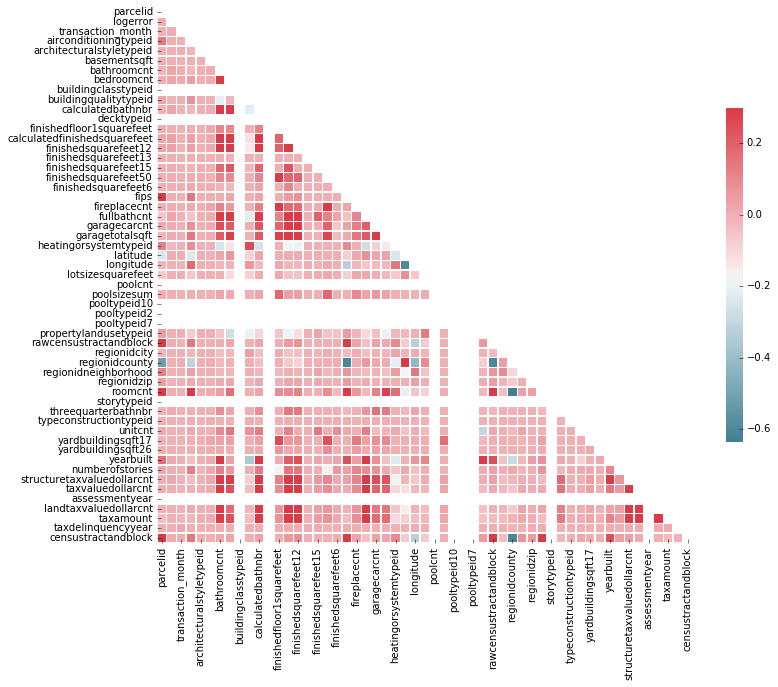

In [25]:
# Generate a mask for the upper triangle
mask = np.zeros_like(pearson, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pearson, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [27]:
# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df_null_to_mean.columns if col not in ['logerror'] if train_df_null_to_mean[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_null_to_mean[col].values, train_df_null_to_mean.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

/Users/adrienctx/anaconda/envs/dev3/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/adrienctx/anaconda/envs/dev3/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


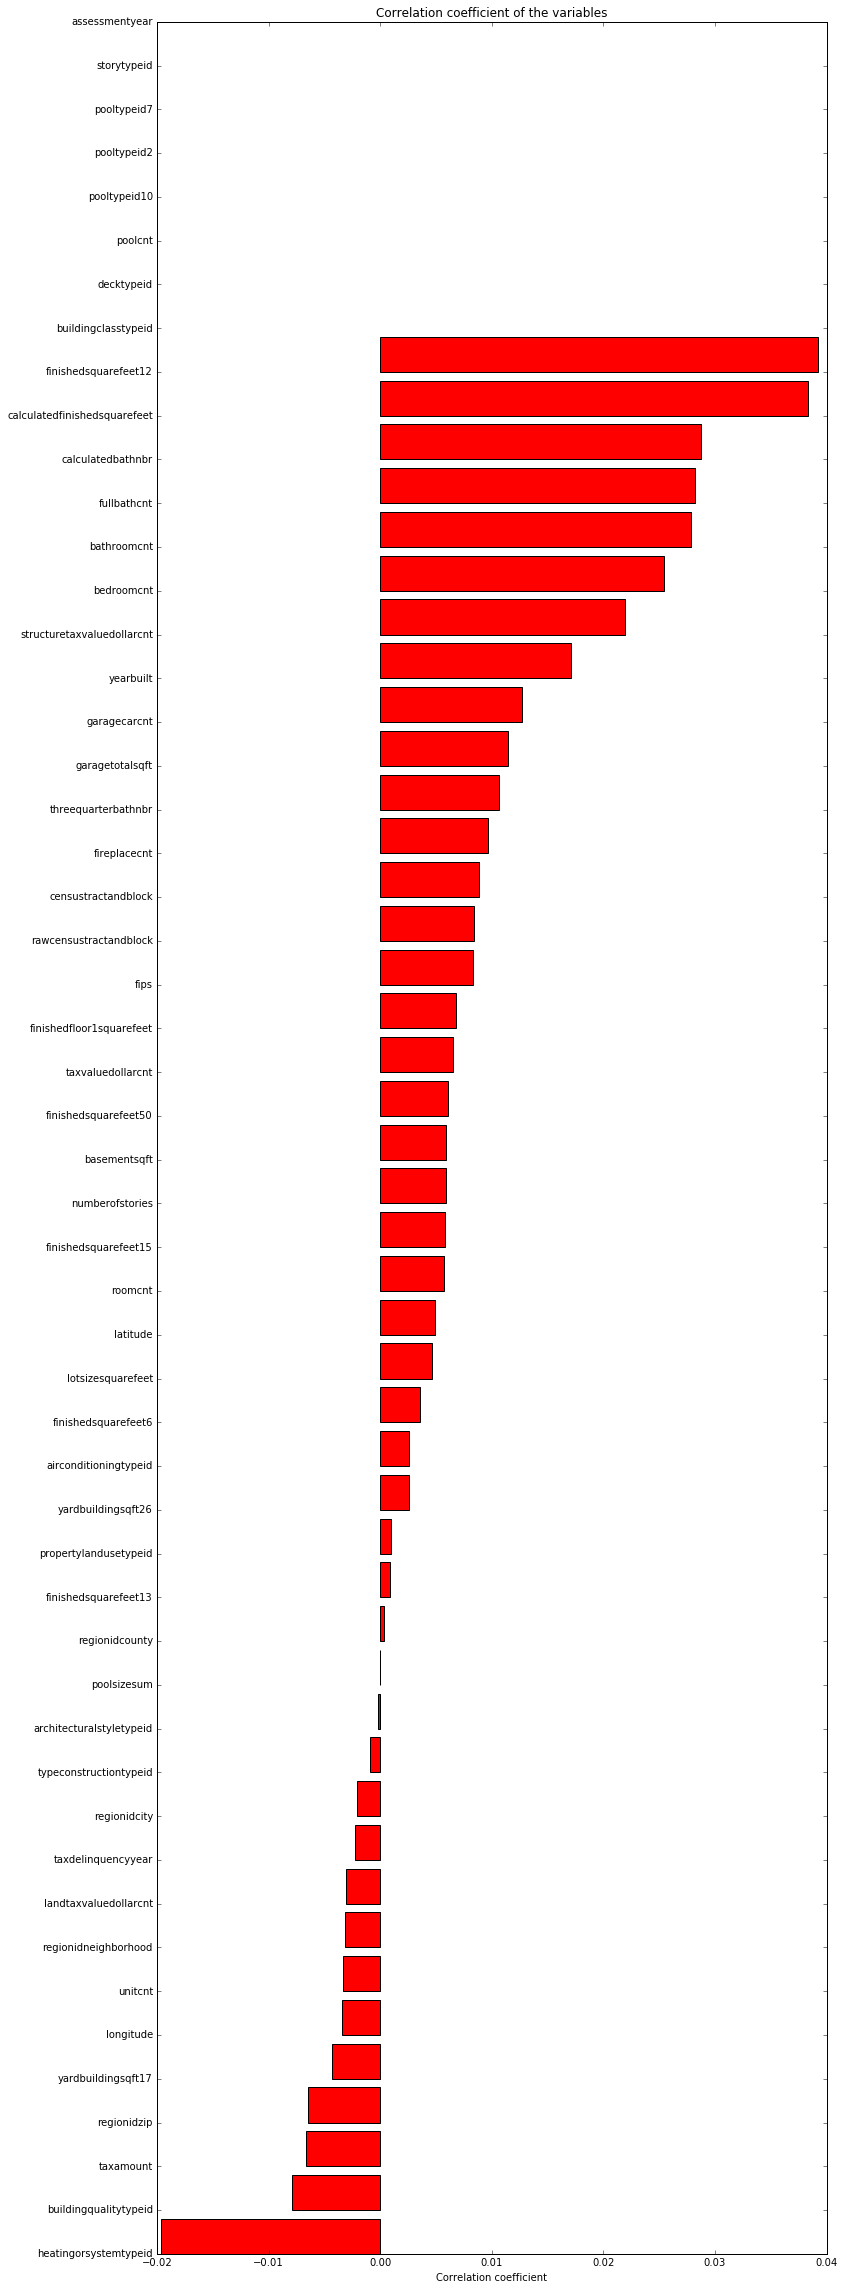

In [28]:
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='r')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

The correlation of the target variable with the given set of variables are low overall. 

There are few variables at the top of this graph without any correlation values. I guess they have only one unique value and hence no correlation value. Let us confirm the same.

In [29]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df_null_to_mean[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


Let us take the variables with high correlation values and then do some analysis on them. 

In [30]:
corr_df_sel = corr_df[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
21,heatingorsystemtypeid,-0.019648
45,structuretaxvaluedollarcnt,0.021935
4,bedroomcnt,0.025467
3,bathroomcnt,0.027889
18,fullbathcnt,0.028169
7,calculatedbathnbr,0.028758
10,calculatedfinishedsquarefeet,0.038341
11,finishedsquarefeet12,0.039248


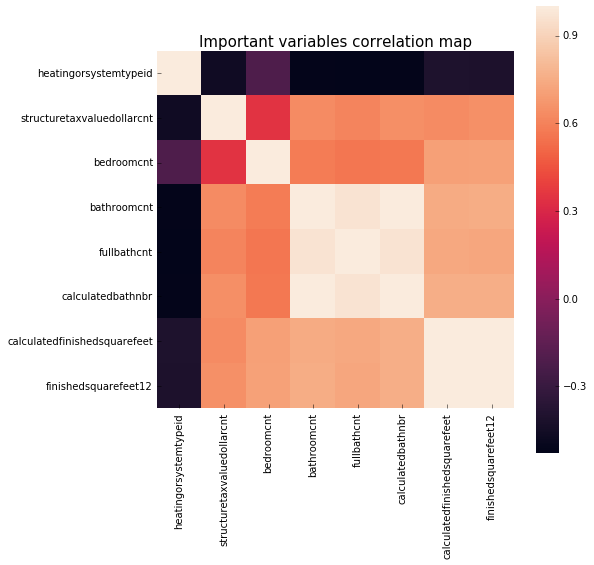

In [31]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

The important variables themselves are very highly correlated.! Let us now look at each of them.

**Finished SquareFeet 12:**

Let us seee how the finished square feet 12 varies with the log error.

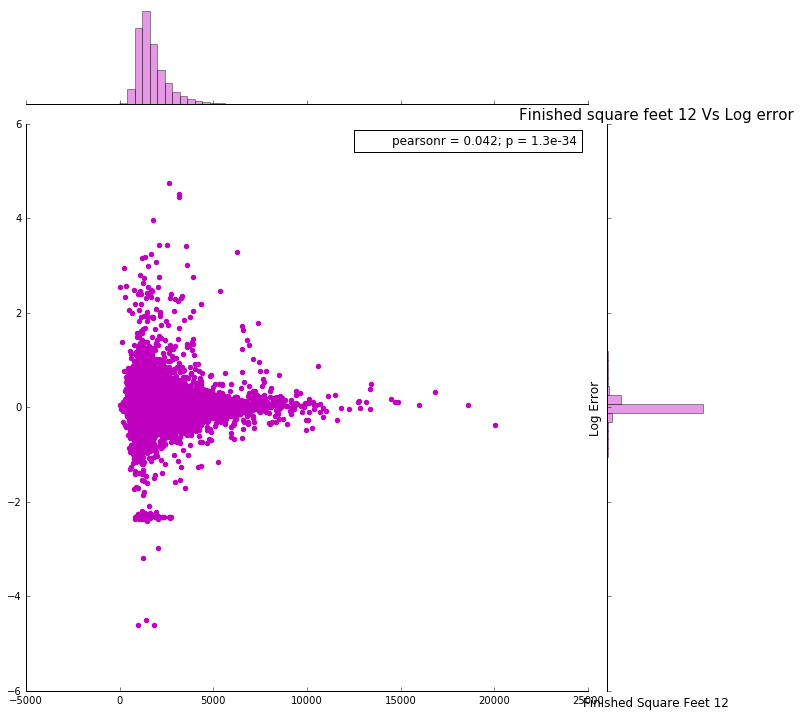

In [32]:
col = "finishedsquarefeet12"
# ulimit = np.percentile(train_df[col].values, 99.5)
# llimit = np.percentile(train_df[col].values, 0.5)
# train_df[col][train_df[col]>ulimit] = ulimit
# train_df[col][train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.finishedsquarefeet12.values, y=train_df.logerror.values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Seems the range of logerror narrows down with increase in finished square feet 12 variable. Probably larger houses are easy to predict?

**Calculated finished square feet:**

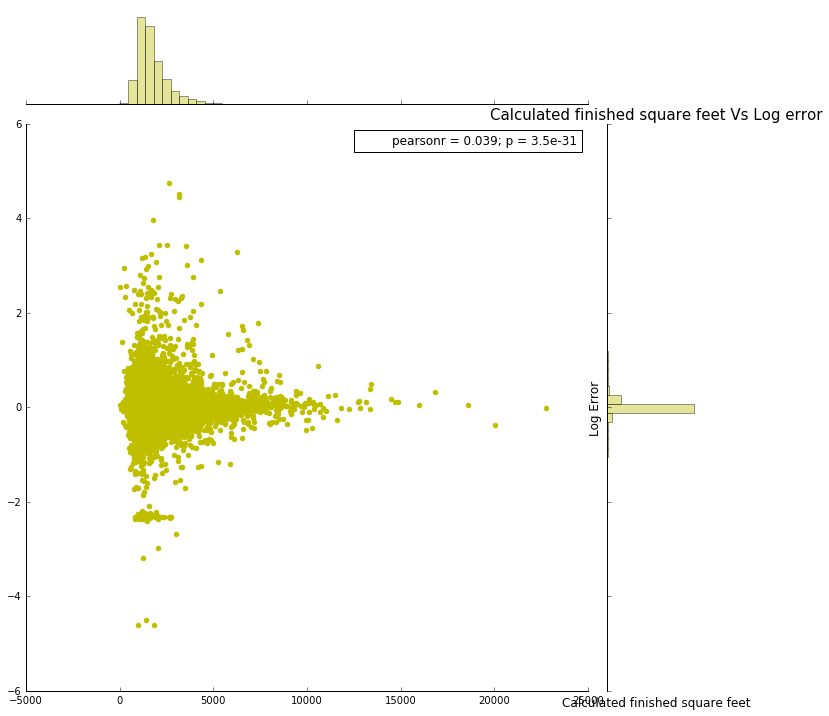

In [33]:
col = "calculatedfinishedsquarefeet"
# ulimit = np.percentile(train_df[col].values, 99.5)
# llimit = np.percentile(train_df[col].values, 0.5)
# train_df[col][train_df[col]>ulimit] = ulimit
# train_df[col][train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

Here as well the distribution is very similar to the previous one. No wonder the correlation between the two variables are also high.

**Bathroom Count:**

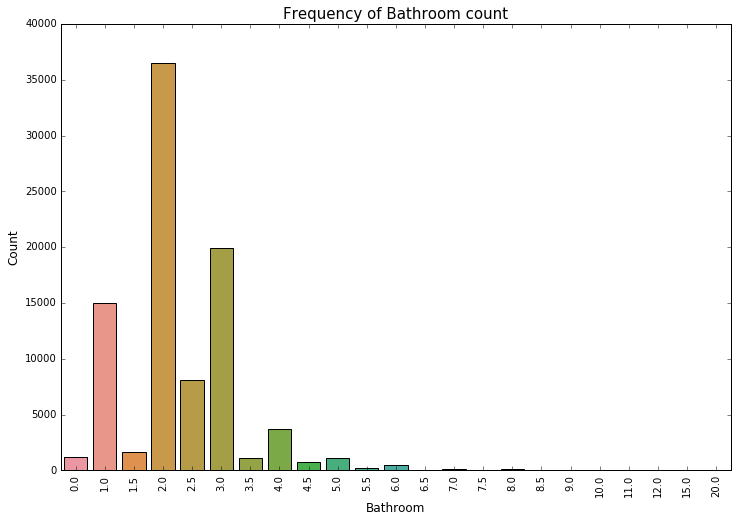

In [34]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

There is an interesting 2.279 value in the bathroom count. Thanks fillna with mean values :(
Now let us check how the log error changes based on this.

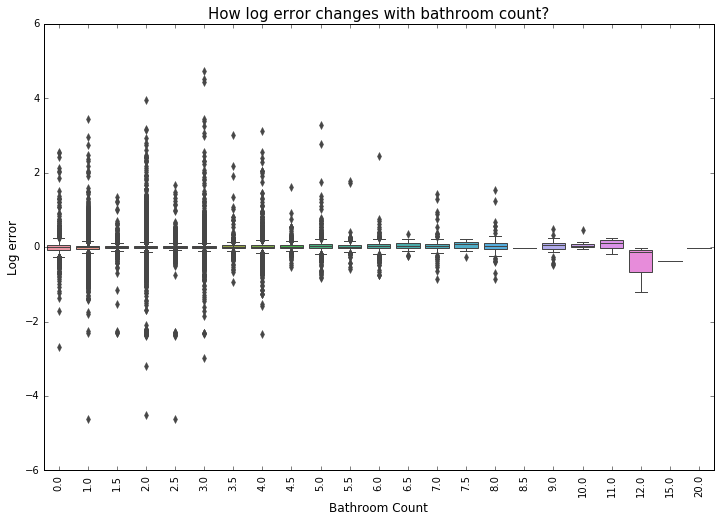

In [35]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

**Bedroom count:**

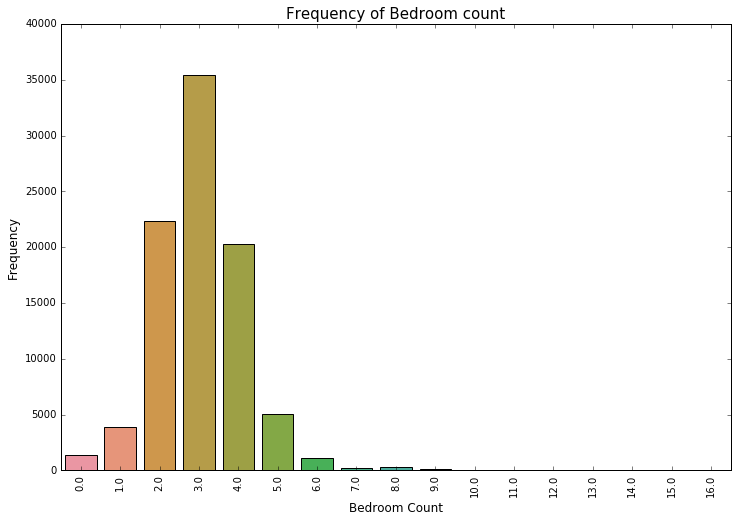

In [36]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

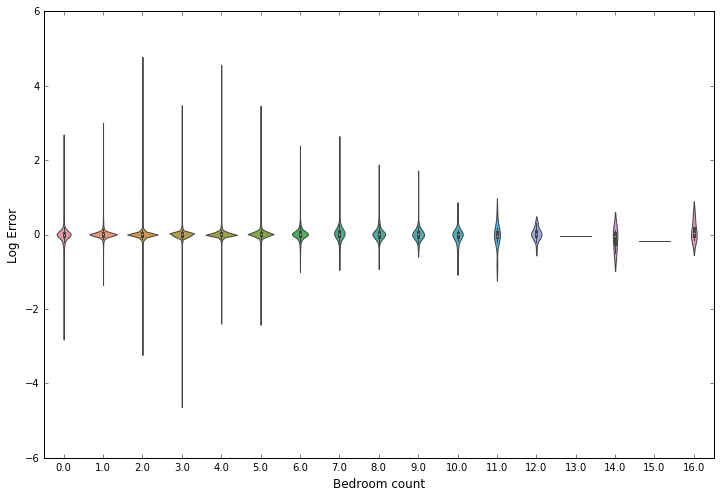

In [37]:
# train_df['bedroomcnt'][train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

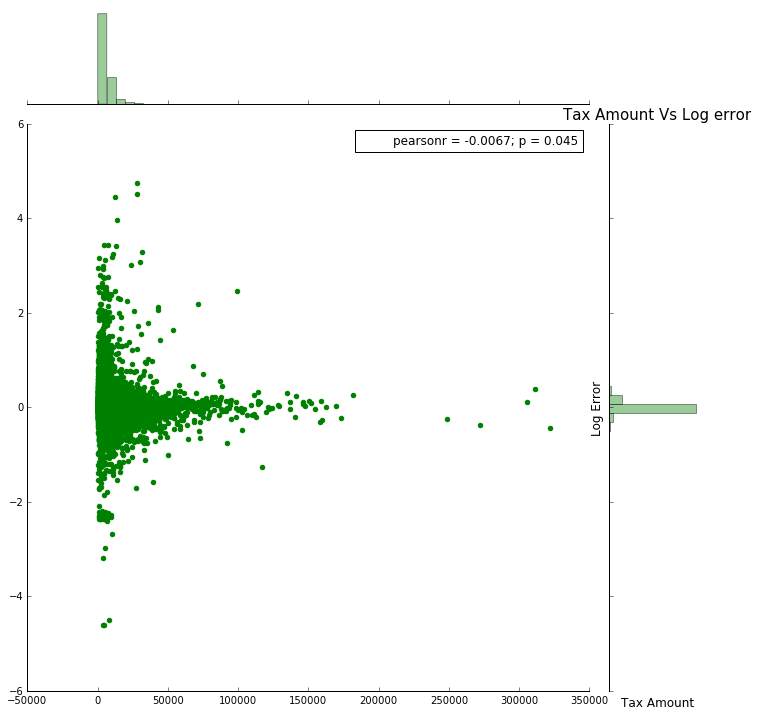

In [38]:
col = "taxamount"
# ulimit = np.percentile(train_df[col].values, 99.5)
# llimit = np.percentile(train_df[col].values, 0.5)
# train_df[col][train_df[col]>ulimit] = ulimit
# train_df[col][train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

**YearBuilt:**

Let us explore how the error varies with the yearbuilt variable.

/Users/adrienctx/anaconda/envs/dev3/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/adrienctx/anaconda/envs/dev3/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/adrienctx/anaconda/envs/dev3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


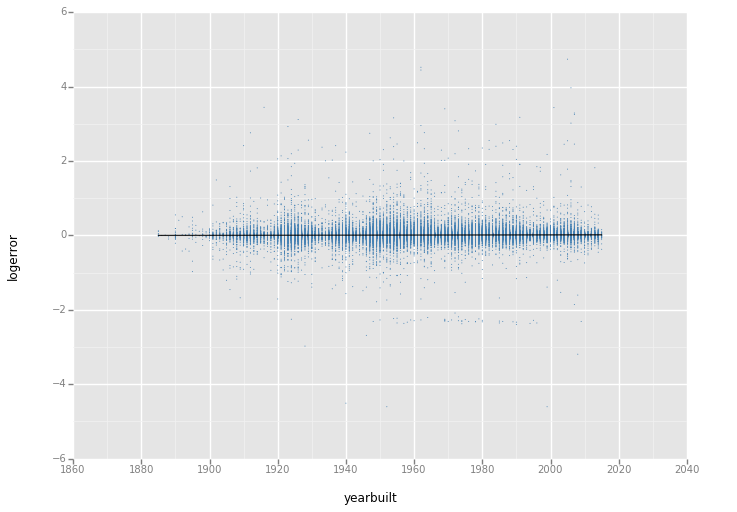

<ggplot: (-9223372036560015893)>

In [39]:
from ggplot import *
ggplot(aes(x='yearbuilt', y='logerror'), data=train_df) + \
    geom_point(color='steelblue', size=1) + \
    stat_smooth()

There is a minor incremental trend seen with respect to built year.

Now let us see how the logerror varies with respect to latitude and longitude.

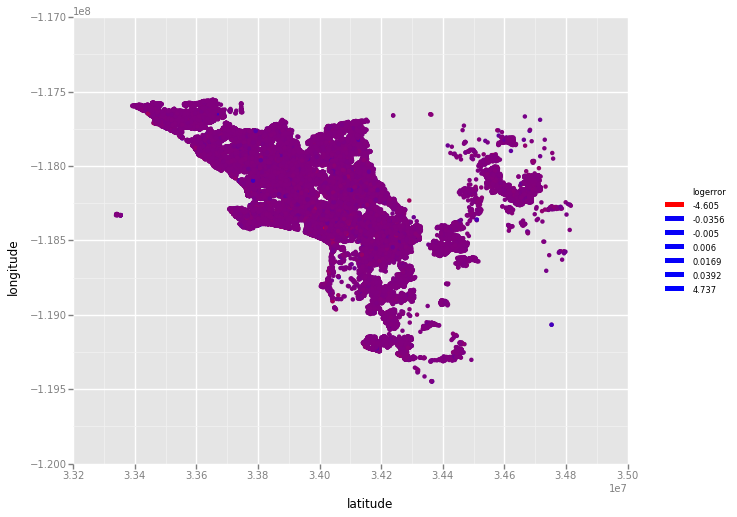

<ggplot: (346729164)>

In [40]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

There are no visible pockets as such with respect to latitude or longitude atleast with the naked eye.

Let us take the variables with highest positive correlation and highest negative correlation to see if we can see some visible patterns.

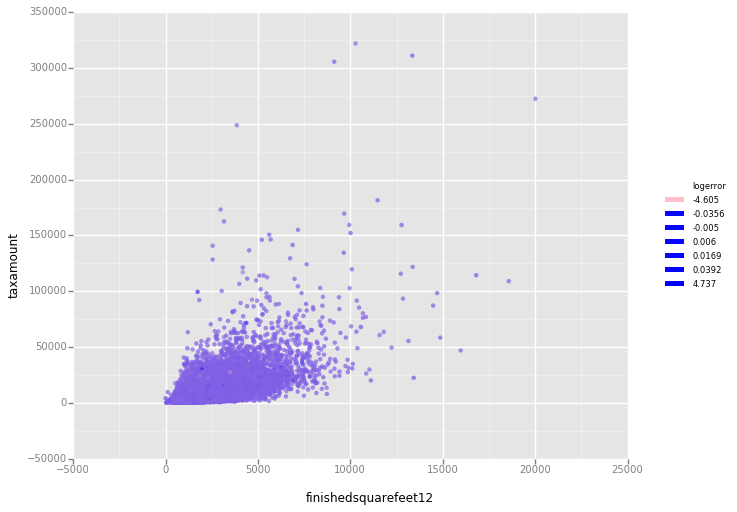

<ggplot: (300440261)>

In [41]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
    geom_point(alpha=0.7) + \
    scale_color_gradient(low = 'pink', high = 'blue')

## Making predictions

We had an understanding of important variables from the univariate analysis. But this is on a stand alone basis and also we have linearity assumption. Now let us build a non-linear model to get the important variables by building Extra Trees model.

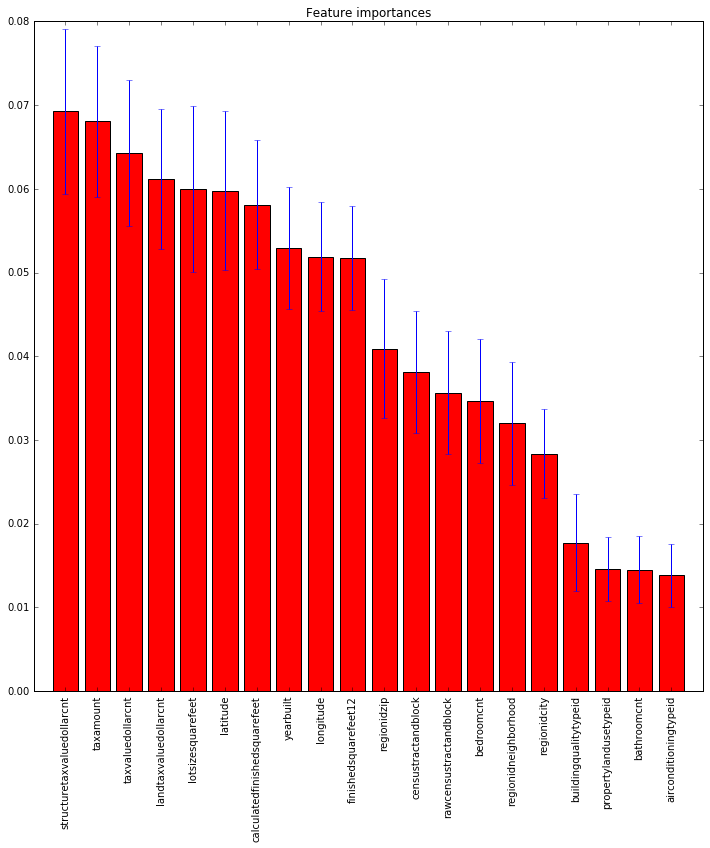

In [42]:
train_y = train_df_null_to_mean['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df_blind = train_df_null_to_mean.copy()
train_df_blind = train_df_blind.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month']+cat_cols, axis=1)
feat_names = train_df_blind.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df_blind, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

Seems "tax amount" is the most importanct variable followed by "structure tax value dollar count" and "land tax value dollor count"



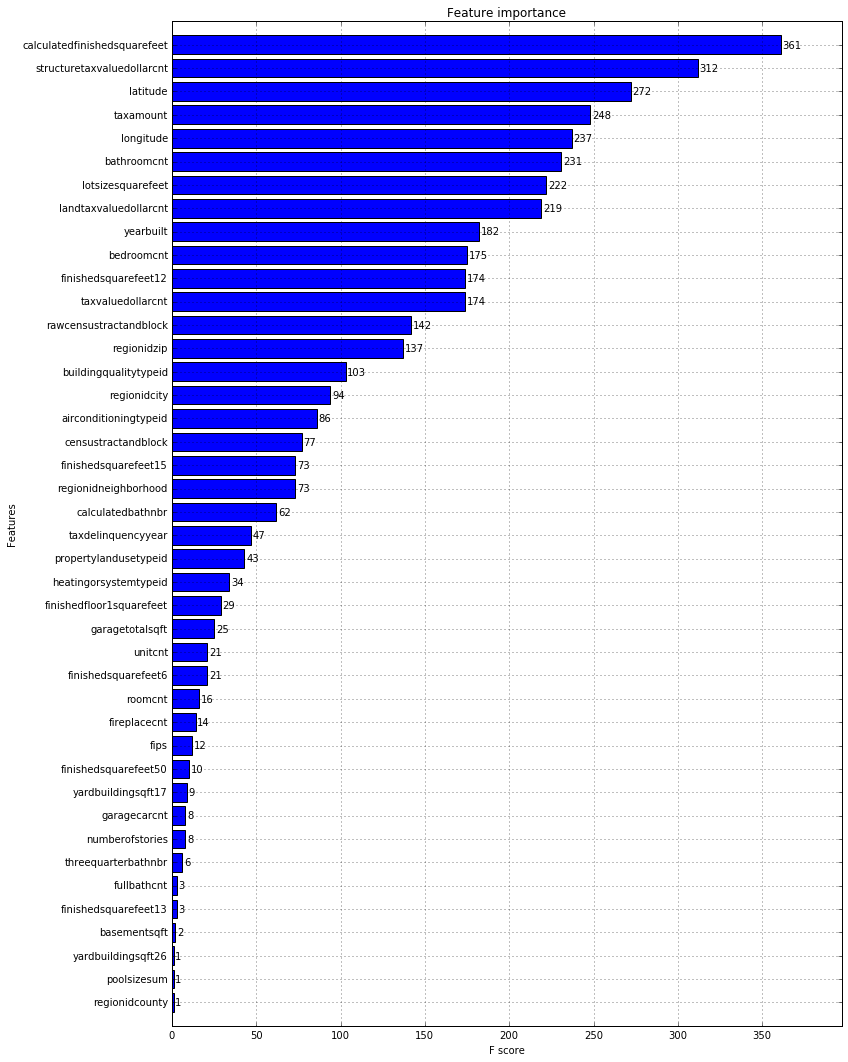

In [43]:
import xgboost as xgb
y_train = train_df_null_to_mean["logerror"].values.astype(np.float32)
y_mean = np.mean(y_train)
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'base_score': y_mean,
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(train_df_blind, train_y, feature_names=train_df_blind.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Using xgboost, the important variables are 'structured tax value dollar count' followed by 'latitude' and 'calculated finished square feet' 

In [44]:
print("   Read sample file ...")
sample = pd.read_csv('../input/sample_submission.csv')
print("   ...")
sample['parcelid'] = sample['ParcelId']
print("   Merge with property data ...")
df_test = sample.merge(prop_df, on='parcelid', how='left')
print("   ...")
del sample

   Read sample file ...
   ...
   Merge with property data ...
   ...


In [45]:
x_test = df_test[train_df_blind.columns]

In [46]:
print( "\nPredicting with XGBoost ...")
dtest = xgb.DMatrix(x_test)
xgb_pred1 = model.predict(dtest)

print( "\nFirst XGBoost predictions:" )
print( pd.DataFrame(xgb_pred1).head() )


Predicting with XGBoost ...

First XGBoost predictions:
          0
0  0.841167
1  0.616168
2  0.576004
3  0.721669
4  0.559349


In [47]:
test_dates = ['2016-10-01','2016-11-01','2016-12-01','2017-10-01','2017-11-01','2017-12-01']
test_columns = ['201610','201611','201612','201710','201711','201712']
submission = pd.read_csv("../input/sample_submission.csv")
test = pd.merge(submission, prop_df, how='left', left_on='ParcelId', right_on='parcelid')

print( "\nPredicting with OLS and combining with XGB/LGB/baseline predicitons: ..." )
for i in range(len(test_dates)):
    test['transactiondate'] = test_dates[i]
    submission[test_columns[i]] = [float(format(x, '.4f')) for x in xgb_pred1]
    print('predict...', i)

print( "\nCombined XGB/LGB/baseline/OLS predictions:" )
print( submission.head() )


Predicting with OLS and combining with XGB/LGB/baseline predicitons: ...
predict... 0
predict... 1
predict... 2
predict... 3
predict... 4
predict... 5

Combined XGB/LGB/baseline/OLS predictions:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147  0.8412  0.8412  0.8412  0.8412  0.8412  0.8412
1  10759547  0.6162  0.6162  0.6162  0.6162  0.6162  0.6162
2  10843547  0.5760  0.5760  0.5760  0.5760  0.5760  0.5760
3  10859147  0.7217  0.7217  0.7217  0.7217  0.7217  0.7217
4  10879947  0.5593  0.5593  0.5593  0.5593  0.5593  0.5593


In [48]:
##### WRITE THE RESULTS

from datetime import datetime

print( "\nWriting results to disk ..." )
submission.to_csv('../output/sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

print( "\nFinished ...")


Writing results to disk ...

Finished ...
